In [1]:
import cv2 
import numpy as np 
import scipy 


def gaussian1DKernel(sigma):
    s = sigma * 5 
    x = np.arange(-s,s).reshape(1,-1)
    g = 1/(np.sqrt(np.pi * sigma**2)) *np.exp(-x**2/(2*sigma**2))
    gd = -x/(sigma ** 2) * g 
    
    g /= np.sum(g) 
    gd /= np.sum(gd)
    
    return g,gd 


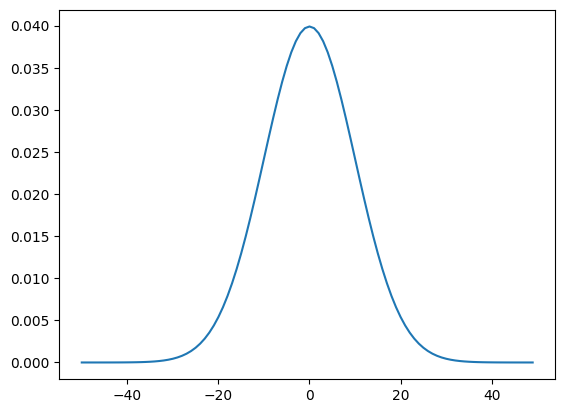

In [2]:
import matplotlib.pyplot as plt 
x = np.arange(-10*5,10*5)

g,gd = gaussian1DKernel(10)

plt.plot(x,g.flatten())
plt.show()

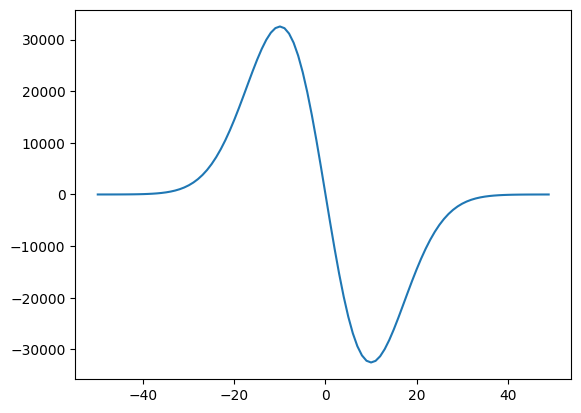

In [35]:
plt.plot(x,gd.flatten())

## Exercise 6.2

Now create the function `I, Ix, Iy = gaussianSmoothing(im, sigma)`, where `I` is the Gaussian smoothed image of `im`, and `Ix` and `Iy` are the smoothed derivatives of the image `im`. The `im` is the original image and `sigma` is the width of the Gaussian.

Remember to convert the image `im` to a single channel (greyscale) and floating point, so you are able to do the convolutions.

Using the `g, gd = gaussian1DKernel(sigma)` function, how would you do 2D smoothing?

Tip: Using a 1D kernel in one direction e.g. x is independent of kernels in the other directions.

What happens if `sigma = 0`? What should the function return if it supported that?

Use the smoothing function on your test image. Do the resulting images look correct?


In [36]:

def gaussianSmoothing(im,sigma):
    
    g,gd = gaussian1DKernel(sigma) 
    # Conolve with a gaussian 
    x_direction = scipy.ndimage.convolve(im,g)
    i = scipy.ndimage.convolve(x_direction,g.T) 
    
    #i/= np.sum(i,axis=1)

    i_y = cv2.filter2D(im,-1,gd.T) 
    i_y = cv2.filter2D(i_y,-1,g)

    i_x = cv2.filter2D(im,-1,gd)
    i_x = cv2.filter2D(i_x,-1,g.T)
    return i,i_x,i_y


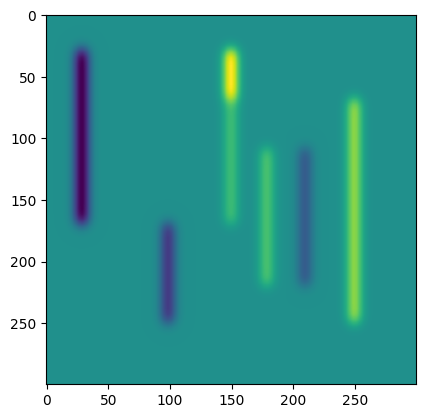

In [37]:

folder_path = "week06_data/" 

img_path = "TestIm1.png"
img = cv2.imread(folder_path + img_path)[:,:,::-1]

im_grey = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
im_grey = im_grey.astype('float')

i,ix,iy = gaussianSmoothing(im_grey,5)
plt.imshow(ix)

In [38]:
def structureTensor(im,sigma,epsilon):
    i,ix,iy = gaussianSmoothing(im,sigma)

    c00,_,_ = gaussianSmoothing(ix**2,epsilon)
    c01,_,_ = gaussianSmoothing(iy**2,epsilon)

    c10,_,_ = gaussianSmoothing(ix*iy,epsilon)

    C = np.array([[c00,c10],[c10,c01]])
    return C 

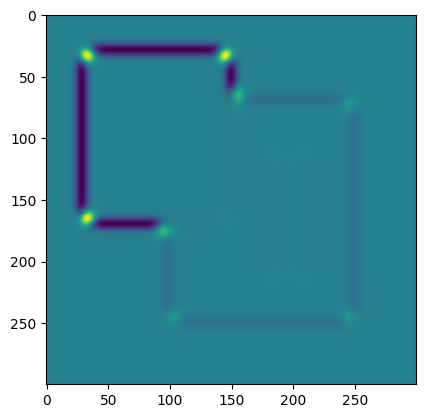

In [39]:
C = structureTensor(im_grey,5,10)

def harrisMeasure(im,sigma,epsilon,k): 
    C = structureTensor(im,sigma,epsilon) 
    a,b,c = C[0][0] , C[1][1],C[0][1] 
    r = a*b -c**2 - k*(a+b)**2 

    return r


r = harrisMeasure(im_grey,5,4,0.06) 
plt.imshow(r)

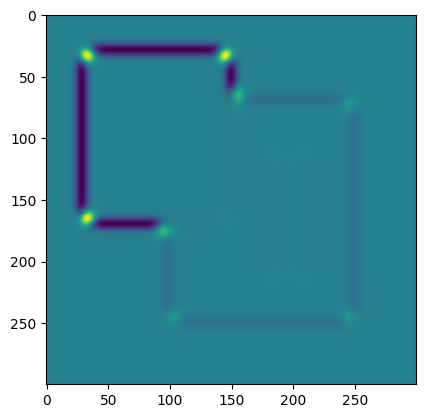

In [40]:
r = harrisMeasure(im_grey,5,4,0.06) 
plt.imshow(r)

##  Exercise 6.5
* Finally, crxate the function c = cornerDetector(im, sigma, epsilon, k, tau) where c is a
list of points where r is the local maximum and larger than some relative threshold i.e.
r(x, y) > tau.
3
To get local maxima, you should implement non-maximum suppression, see the slides or Sec. 4.3.1
in the LN. Non-maximum suppression ensures that r(x, y) > r(x ± 1, y) and r(x, y) > r(x, y ± 1).
Once you have performed non-maximum suppression you can find the coordinates of the points
using np.where.
Use the corner detector on your test image. Does it find all the corners, or too many corners?

In [47]:
import numpy as np

def max_supr(r, x, y):
    # Ensure we do not go out of bounds
    if x == 0 or y == 0 or x == r.shape[0] - 1 or y == r.shape[1] - 1:
        return False
    return (r[x, y] > r[x+1, y]) and (r[x, y] >= r[x-1, y]) and (r[x, y] > r[x, y+1]) and (r[x, y] >= r[x, y-1])

def cornerDetector(im, sigma, epsilon, k, tau):
    # Assume harrisMeasure is a function you've defined elsewhere that computes the Harris corner response
    r = harrisMeasure(im, sigma, epsilon, k)
    N, M = r.shape
    
    # Initialize a mask with zeros
    corner_mask = np.zeros_like(r, dtype=bool)
    
    # Iterate over the array excluding the border pixels
    for x in range(1, N-1):
        for y in range(1, M-1):
            if max_supr(r, x, y) and r[x, y] > tau:
                corner_mask[x, y] = True
    
    # Find coordinates of all pixels that are considered corners
    corners = np.argwhere(corner_mask)
    
    return corners


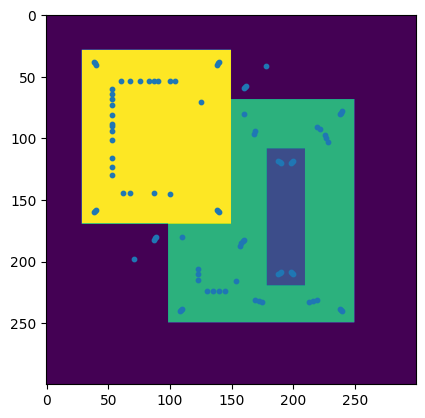

In [99]:
corners = cornerDetector(im_grey,5,1.,0.06,150)
plt.imshow(im_grey)
plt.scatter(corners[:,1],corners[:,0],s=10)


In [106]:
H = np.load("harris.npy", allow_pickle=True).item()
k = 0.06 
tau = 516 


In [121]:
gix = H['g*(I_x^2)']
giy = H['g*(I_y^2)']
gixy = H['g*(I_x I_y)']


k = 0.06
tau = 516
C = np.array([[gix,gixy],[gixy,giy]])
a,b,c = C[0][0] , C[1][1],C[0][1] 
r = a*b -c**2 - k*(a+b)**2 

N, M = r.shape
    
    # Initialize a mask with zeros
corner_mask = np.zeros_like(r, dtype=bool)
    
    # Iterate over the array excluding the border pixels
for x in range(1, N-1):
    for y in range(1, M-1):
        if max_supr(r, x, y) and r[x, y] > tau:
            corner_mask[x, y] = True
    
    # Find coordinates of all pixels that are considered corners
corners = np.argwhere(corner_mask)

In [122]:
corners

array([[2, 1]])